# Optimizing how the prediction results are served

In this notebook I change how predictions are served by providing the results that add up to 95% certainty, 
instead of simply the top 5.

If there are more or less than 5 in the certainty range I implement body-type consensus

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from custom.tools import pickle_variable_to_path

### Get necessary data

In [32]:
WORKING_DIR = os.getcwd()
OPEN_DIR = os.path.join(WORKING_DIR, 'data', 'notebooks', '5_model_validation')
DATA_DIR = os.path.join(WORKING_DIR, 'data', 'InceptionV3')
LOOKUP_PATH = os.path.join(DATA_DIR, 'I_15_lookup_dict.pkl')

with open(os.path.join(OPEN_DIR, 'label_category_dict_corrected.pkl'), 'rb') as f:
    label_category_dict = pickle.load(f)
    
with open(os.path.join(OPEN_DIR, 'test_y_true.pkl'), 'rb') as f:
    test_y_true = pickle.load(f)

with open(os.path.join(OPEN_DIR, 'test_y_pred.pkl'), 'rb') as f:
    test_y_pred = pickle.load(f)
    
with open(os.path.join(LOOKUP_PATH), 'rb') as f:
    lookup_dict = pickle.load(f)

### Show what the top-5 method provides in terms of body styles

In [62]:
def find_top_k_prediction_indices(prediction_array_row, **kwargs):
    """
    prediction array row should be shape (classes,)
    **kwargs are so that the function can be dropped into make_pred_dict_list function below. 
    In this case the only kwarg should be k=int, where int is an integer of the number of top results desired
    """
    # find the indices of the top 5 predictions for each row
    top_idxs = np.argpartition(prediction_array_row, -(kwargs['k']+1))[-(kwargs['k']):]
    # sort them from greatest to lowest
    top_idxs = top_idxs[np.argsort(prediction_array_row[top_idxs])][::-1]
    return top_idxs

# show that it worked
print(test_y_pred[0, find_top_k_prediction_indices(test_y_pred[0,:], k=3)])

[  9.99222636e-01   7.47231010e-04   2.20297807e-05]


In [207]:
def make_pred_dict_list(y_true, y_pred, lookup_dict, label_category_dict, index_finder, **kwargs):
    """
    
    **kwargs can be:
    k=int if using index_finder function with top k functionality
    percent=int if using index_finder function with top percent functionality
    
    makes a list of pred_dicts for each prediction with the following keys:
    -true_label
    -true_git body
    -pred_labels: list of predicted labels in order of probability
    -pred_bodies: list of bodies associated with pred_labels, in same order.
    -pred_probs: list of probabilities associated with pred_labels, in same order 
                (only included if index_finder == find_top_k_prediction_indices_and_probs)
    """
    
    if index_finder == find_top_k_prediction_indices_and_probs:
        probs = True
    else:
        probs = False
    
    prediction_dict_list = []
    for row in range(y_true.shape[0]):
        prediction_dict = {'pred_labels': [], 'pred_bodies': []}
        true_idx = np.argmax(y_true[row,:])
        true_label = lookup_dict[true_idx]
        prediction_dict['true_label'] = true_label
        prediction_dict['true_body'] = label_category_dict[true_label]['body_style']
        if probs:
            top_idxs, top_probs = index_finder(y_pred[row,:], **kwargs)
        else:
            top_idxs = index_finder(y_pred[row,:], **kwargs)
        for i in top_idxs:
            pred_label = lookup_dict[i]
            pred_body = label_category_dict[pred_label]['body_style']
            prediction_dict['pred_labels'].append(pred_label)
            prediction_dict['pred_bodies'].append(pred_body)
            if probs:
                prediction_dict['pred_probs'] = top_probs
        prediction_dict_list.append(prediction_dict)
    return prediction_dict_list

In [227]:
def characterize_pred_list(prediction_dict_list,
                           prediction_label, 
                           consensus=False):
    correct_id_body = 0
    correct_id = 0
    incorrect = 0
    wrong_body_groupings = []
    for prediction_dict in prediction_dict_list:
        if consensus:
            pred_body_set = sorted(list(set(prediction_dict['consensus_bodies'])))
        else:
            pred_body_set = sorted(list(set(prediction_dict['pred_bodies'])))
        
        # correct cases
        if prediction_dict['true_label'] in prediction_dict[prediction_label]:
            if len(pred_body_set) == 1:
                correct_id_body += 1
            else:
                correct_id += 1
                wrong_body_groupings.append((pred_body_set, prediction_dict))
        # incorrect cases
        else:
            incorrect += 1
    
    wrong_body_sets = []
    tracker = []
    for group in wrong_body_groupings:
        test_group = group[0]
        if test_group not in tracker:
            tracker.append(test_group)
            wrong_body_sets.append(group)
    
    total = (correct_id_body + correct_id + incorrect)
    assert total==len(prediction_dict_list), 'total is wrong'
    print('fraction correct: {}'.format(round(correct_id_body/total, 3)))
    print('fraction correct with wrong body in results: {}'.format(round(correct_id/total, 3)))
    print('fraction incorrect: {}'.format(round(incorrect/total, 3)))
    print('number of different wrong body groupings: {}' .format(len(wrong_body_sets)))
    
    return wrong_body_sets, tracker

In [193]:
top_5_pred_dict_list = make_pred_dict_list(
    test_y_true, test_y_pred,
    lookup_dict, label_category_dict,
    find_top_k_prediction_indices, k=5
)

In [194]:
top_5_wrong_body, top_5_tracker =\
characterize_pred_list(top_5_pred_dict_list, 'pred_labels')

fraction correct: 0.158
fraction correct with wrong body in results: 0.79
fraction incorrect: 0.052
number of different wrong body groupings: 152


Top-5 results have a very high fraction (0.79) of correct results with other body types thrown into them...
see if serving only the results with 95% confidence improves this

### Test if serving 95% confidence instead of top-5 improves wrong body listings

In [63]:
def find_top_percent_prediction_indices(prediction_array_row, **kwargs):
    """
    prediction array row should be shape (classes,)
    """
    # sort them from greatest to lowest
    top_idxs = np.argsort(prediction_array_row)[::-1]
#     print(top_idxs)
    
    # only select ones that add up to 99% certainty
    selected = []
    certainty = 0
    i = 0
    while certainty <= kwargs['percent']/100:
#         print(top_idxs[i])
        selected.append(top_idxs[i])
        certainty += prediction_array_row[top_idxs[i]]
        i += 1
    return selected

# show that it worked
test_i = 1
print(test_y_pred[test_i, find_top_percent_prediction_indices(test_y_pred[test_i,:], percent=95)])

[ 0.42262146  0.31554991  0.16753168  0.06199163]


In [195]:
percent_pred_dict_list = make_pred_dict_list(
    test_y_true, test_y_pred,
    lookup_dict, label_category_dict,
    find_top_percent_prediction_indices, percent=95
)

In [196]:
percent_wrong_body, percent_tracker =\
characterize_pred_list(percent_pred_dict_list, 'pred_labels')

fraction correct: 0.692
fraction correct with wrong body in results: 0.227
fraction incorrect: 0.08
number of different wrong body groupings: 102


It helps a lot! 0.23 with wrong body (compared with 0.79 for top-5) 
and the fraction incorrect only suffers by 0.028 (0.08 - 0.052)

Now look at how different the result lengths are:

In [197]:
percent_result_lengths = []
for pred_dict in percent_pred_dict_list:
    percent_result_lengths.append(len(pred_dict['pred_labels']))
print('number of lengths captured:', len(percent_result_lengths))
print('max length:', max(percent_result_lengths))
print('min length:', min(percent_result_lengths))

number of lengths captured: 2428
max length: 68
min length: 1


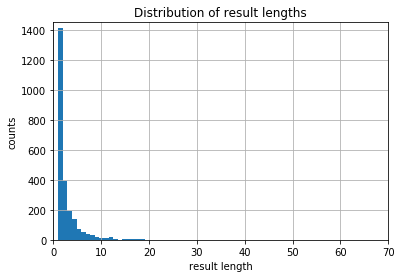

In [201]:
n, bins, patches = plt.hist(percent_result_lengths, 70)
plt.xlabel('result length')
plt.ylabel('counts')
plt.title('Distribution of result lengths')
plt.axis([0, 70, 0, 1450])
plt.grid(True)
plt.show()

### Percent + consensus body type

Most of the results are just one or two long. I would rather always display 5,
so implement a version where:

- if you have less than five, add the next five __that match the body styles already included__ (otherwise its just top-5)
- if you have more than five, truncate at five

In [206]:
def find_top_k_prediction_indices_and_probs(prediction_array_row, **kwargs):
    """
    prediction array row should be shape (classes,)
    **kwargs are so that the function can be dropped into make_pred_dict_list function below. 
    In this case the only kwarg should be k=int, where int is an integer of the number of top results desired
    """
    # find the indices of the top 5 predictions for each row
    top_idxs = np.argpartition(prediction_array_row, -(kwargs['k']+1))[-(kwargs['k']):]
    # sort them from greatest to lowest
    top_idxs = top_idxs[np.argsort(prediction_array_row[top_idxs])][::-1]
    top_probs = prediction_array_row[top_idxs]
    return top_idxs, top_probs

# show that it worked
print(test_y_pred[0, find_top_k_prediction_indices(test_y_pred[0,:], k=3)])
print(find_top_k_prediction_indices_and_probs(test_y_pred[0,:], k=3))

[  9.99222636e-01   7.47231010e-04   2.20297807e-05]
(array([119, 110, 143]), array([  9.99222636e-01,   7.47231010e-04,   2.20297807e-05], dtype=float32))


In [219]:
top_195_pred_prob_dict_list = make_pred_dict_list(
    test_y_true, test_y_pred,
    lookup_dict, label_category_dict,
    find_top_k_prediction_indices_and_probs, k=195
)

In [220]:
top_195_pred_prob_dict_list[0]

{'pred_bodies': ['PICKUP',
  'PICKUP',
  'SUV',
  'SUV',
  'PICKUP',
  'SUV',
  'PICKUP',
  'VAN',
  'PICKUP',
  'PICKUP',
  'PICKUP',
  'PICKUP',
  'SUV',
  'PICKUP',
  'PICKUP',
  'SUV',
  'VAN',
  'SUV',
  'SUV',
  'VAN',
  'SUV',
  'PICKUP',
  'PICKUP',
  'SUV',
  'SUV',
  'VAN',
  'SUV',
  'SUV',
  'SUV',
  'SUV',
  'PICKUP',
  'WAGON',
  'SUV',
  'PICKUP',
  'SUV',
  'PICKUP',
  'PICKUP',
  'HATCHBACK',
  'VAN',
  'HATCHBACK',
  'PICKUP',
  'SUV',
  'HATCHBACK',
  'SUV',
  'SUV',
  'MINIVAN',
  'SUV',
  'SUV',
  'CONVERTIBLE',
  'MINIVAN',
  'SEDAN',
  'WAGON',
  'SUV',
  'CONVERTIBLE',
  'SEDAN',
  'CONVERTIBLE',
  'SUV',
  'SEDAN',
  'COUPE',
  'CONVERTIBLE',
  'CONVERTIBLE',
  'SEDAN',
  'SUV',
  'MINIVAN',
  'CONVERTIBLE',
  'SEDAN',
  'WAGON',
  'SUV',
  'PICKUP',
  'COUPE',
  'SEDAN',
  'SEDAN',
  'COUPE',
  'CONVERTIBLE',
  'SEDAN',
  'SUV',
  'VAN',
  'COUPE',
  'SUV',
  'SUV',
  'SEDAN',
  'SUV',
  'SUV',
  'SEDAN',
  'SUV',
  'MINIVAN',
  'HATCHBACK',
  'SEDAN',
  'VAN'

In [222]:
### Change a pred_dict_list to remove non-consensus body types and present top-k results
def keep_top_k_with_consensus_body(pred_dict_list, k=5, percent=95):
    import collections
    import copy
    pred_dict_list_copy = copy.deepcopy(pred_dict_list)
    for pred_dict in pred_dict_list_copy:
        # find the body_types in the top 95% certainty group:
        probs = pred_dict['pred_probs']
        bodies = pred_dict['pred_bodies']
        i = 0
        total_prob = 0
        top_bodies = []
        while total_prob < percent/100:
            top_bodies.append(bodies[i])
            total_prob += probs[i]
            i += 1
        body_count = collections.Counter(top_bodies)
        most_common_bodies = body_count.most_common(2)
        most_common_bodies = [tup[0] for tup in most_common_bodies]
        pred_dict['consensus_bodies'] = most_common_bodies
        consensus_labels = []
        for i, label in enumerate(pred_dict['pred_labels']):
            if pred_dict['pred_bodies'][i] in most_common_bodies:
                consensus_labels.append(label)
        if len(consensus_labels) < 5:
            print('not enough options to present 5!')
        else:
            truncated_consensus = consensus_labels[:5]
                
        pred_dict['consensus_labels'] = truncated_consensus
    return pred_dict_list_copy

#show that it works 
print(keep_top_k_with_consensus_body(top_195_pred_prob_dict_list[:1]))

[{'pred_labels': ['GMC-Canyon_Extended_Cab-2012', 'Ford-F_150_Regular_Cab-2012', 'Isuzu-Ascender_SUV-2008', 'Dodge-Durango_SUV-2007', 'Ford-F_150_Regular_Cab-2007', 'Ford-Expedition_EL_SUV-2009', 'Chevrolet-Silverado_1500_Hybrid_Crew_Cab-2012', 'Ford-E_Series_Wagon_Van-2012', 'Ford-Ranger_SuperCab-2011', 'Chevrolet-Avalanche_Crew_Cab-2012', 'Chevrolet-Silverado_1500_Extended_Cab-2012', 'Chevrolet-Silverado_1500_Classic_Extended_Cab-2007', 'Chrysler-Aspen_SUV-2009', 'Ford-F_450_Super_Duty_Crew_Cab-2012', 'Dodge-Ram_Pickup_3500_Crew_Cab-2010', 'Buick-Rainier_SUV-2007', 'GMC-Savana_Van-2012', 'GMC-Yukon_Hybrid_SUV-2012', 'Chevrolet-Tahoe_Hybrid_SUV-2012', 'Chevrolet-Express_Van-2007', 'Volvo-XC90_SUV-2007', 'Chevrolet-Silverado_2500HD_Regular_Cab-2012', 'Dodge-Ram_Pickup_3500_Quad_Cab-2009', 'Jeep-Grand_Cherokee_SUV-2012', 'GMC-Terrain_SUV-2012', 'Nissan-NV_Passenger_Van-2012', 'Toyota-Sequoia_SUV-2012', 'Jeep-Liberty_SUV-2012', 'Chevrolet-HHR_SS-2010', 'Toyota-4Runner_SUV-2012', 'HUMMER-

In [223]:
top_5_consensus_dict_list = keep_top_k_with_consensus_body(top_195_pred_prob_dict_list)

In [228]:
top_5_consensus_bodies, top_5_consensus_tracker =\
characterize_pred_list(top_5_consensus_dict_list, 'consensus_labels', consensus=True)

fraction correct: 0.714
fraction correct with wrong body in results: 0.215
fraction incorrect: 0.071
number of different wrong body groupings: 30


Nice! Implementation will provide top-5 labels while even improving the accuracy by a little bit: 
0.71 as opposed to 0.8 with just top_20%

In [231]:
top_5_consensus_bodies[-2]

(['COUPE', 'PICKUP'],
 {'consensus_bodies': ['PICKUP', 'COUPE'],
  'consensus_labels': ['Chevrolet-Silverado_1500_Extended_Cab-2012',
   'Dodge-Dakota_Crew_Cab-2010',
   'Dodge-Dakota_Club_Cab-2007',
   'Nissan-240SX_Coupe-1998',
   'Chevrolet-Avalanche_Crew_Cab-2012'],
  'pred_bodies': ['PICKUP',
   'PICKUP',
   'PICKUP',
   'COUPE',
   'PICKUP',
   'PICKUP',
   'PICKUP',
   'PICKUP',
   'PICKUP',
   'VAN',
   'PICKUP',
   'WAGON',
   'SEDAN',
   'WAGON',
   'SEDAN',
   'SUV',
   'SEDAN',
   'SUV',
   'PICKUP',
   'CONVERTIBLE',
   'SUV',
   'CONVERTIBLE',
   'COUPE',
   'SUV',
   'PICKUP',
   'SEDAN',
   'PICKUP',
   'SEDAN',
   'HATCHBACK',
   'PICKUP',
   'COUPE',
   'SUV',
   'VAN',
   'COUPE',
   'PICKUP',
   'SEDAN',
   'SEDAN',
   'WAGON',
   'HATCHBACK',
   'SEDAN',
   'VAN',
   'SEDAN',
   'COUPE',
   'CONVERTIBLE',
   'PICKUP',
   'COUPE',
   'SUV',
   'SEDAN',
   'CONVERTIBLE',
   'PICKUP',
   'PICKUP',
   'PICKUP',
   'COUPE',
   'SUV',
   'SEDAN',
   'VAN',
   'COUPE',
  